# Overfit Prevention in Image Clasification 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mohanen/noob_vision/blob/master/cnn_classification_overfit_prevention_tf.ipynb)

> we already know how to classify images from [cnn classification](https://colab.research.google.com/github/mohanen/noob_vision/blob/master/cnn_classification_overfit_prevention_tf.ipynb)

## Overfitting 

- Memorizing is not learning, when the trained model only gives good results to training set but fails in validation and/or test then its overfit 
- occurs when things become complex, Trying to keep things simple is the key to solve.

### Most common ways to prevent overfitting in neural networks
1. Get more training data 
  - Its all about data if its possible always get more data
  - Its better to have almost equalent amount of cases for all the classes
2. data-augmentation 
  - Create more datasets from existing ones 
  - Apply random transformations such as rotations, translations, scaling, flip
  - Depending upon the use case we can use weather effect, lens distortions to generate even more data 
3. Reduce the capacity of the network. 
  - If the network is too complex the model will overfit, if its too simple the model will underfit, so its all about finding the sweet spot for your network
  - Always start with simple network with less layers and node and increase the complexity if required
4. Add dropout
  - Not all nodes treated equally some are weak and some are strong
  - The strong nodes always dominates the weak nodes, so turning of the strong nodes will make the network tweak its weights for the weak nodes to improve accuracy with what it have
  - drop some percent of previous nodes to give some extra learning time to lazy learner nodes
5. batch normalization
  - Neuron "$z = g(weights,x) + bias$" fed to a activation func $a=f(z)$
  - After Batch Normalization $z = g(w,x) \qquad z^N = \frac{z-mean_z}{stdev_z} * \gamma + \beta \qquad a = f(z^N)$ 
  - Working on normalized data also speeds up the process
6. Add weight 
  - put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular".
  - L1 regularization - pushes weights towards exactly zero encouraging a sparse model
  - L2 regularization - penalize the weights parameters without making them sparse since the penalty goes to zero for small weights

> Each of the above 6 steps has its own set of parameters to be configured for optimal results, as there is no one size fits all parameters we have to experiment with the values for our scenarios

### Lets use the same steps as [cnn classification](https://colab.research.google.com/github/mohanen/noob_vision/blob/master/cnn_classification_tf.ipynb) with some overfit prevention mechanisms

1. Download and arrange dataset in file system
2. Load the training and valdiation data 
3. Create a CNN Model
4. Train the model
5. Test the model


## Step 1: Download and arrange dataset in file systems

In [2]:
import tensorflow as tf
import numpy as np
import pathlib                  # For folder/file related operations
import matplotlib.pyplot as plt # For plotting graphs and showing images

# Reduce precission and speed thing up 60% on TPU and 3x on Modern GPU - optional
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Download the dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# You don't need to seperate libraries to download and zip file, tensorflow itself has one built one, lets use that
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname="the_dataset", extract=True, cache_dir="./")
# Pathlib allows you to do some path handling operations
data_dir = pathlib.Path(data_dir)
data_dir =  data_dir.parent.joinpath ('flower_photos')

# list the contents of data dir
# "!" indicated shell commands
!ls $data_dir

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5
228818944/228813984 [==============================] - 1s 0us/step
daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


## Step 2: Load the training and validation data 


In [6]:
BATCH_SIZE = 32 # Instead of running all dataset one session its split into multiple batches for faster training and better convergence
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3 # RGB has 3 channels each represensting intensity of Red, Green, Blue 

# To load the image from directory we can use the tensorflow api itself
# training and validation split can also be configured with the same api
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,               # path to dataset
    validation_split=0.2,   # percent of data reserved for validation
    subset="training",      # training or validation subset
    seed=123,               # seed helps in shuffling images same way for both training and validation 
    image_size=(IMG_HEIGHT, IMG_WIDTH), 
    batch_size=BATCH_SIZE   
    )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2,
    subset="validation", 
    seed=123, 
    image_size=(IMG_HEIGHT, IMG_WIDTH), 
    batch_size=BATCH_SIZE)

# store the class names
class_names = train_ds.class_names

# Improves tensorflow performance drastically
train_ds = train_ds.cache()
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache()
val_ds = val_ds.prefetch(tf.data.experimental.AUTOTUNE)

print (class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Step 3: Create a CNN Model


In [8]:
from tensorflow.keras import layers, models

# Prevents over fittting the model
data_augmentation = models.Sequential([
                     layers.experimental.preprocessing.RandomFlip(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
                     layers.experimental.preprocessing.RandomRotation(0.2),
                     layers.experimental.preprocessing.RandomZoom(0.2),
                     layers.experimental.preprocessing.RandomContrast(0.2),
                     layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                     layers.experimental.preprocessing.Rescaling(1./255),
])


# The optimal number of layers, filters varies with scenarios, so its best start with simple network and increase the complexity to get good results
# complexity brings another problem overfitting - we will be discussing this on a different experiment
model = models.Sequential([
                           data_augmentation,
                           layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
                           layers.BatchNormalization(),
                           layers.MaxPooling2D(pool_size=(2,2)),
                           layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
                           layers.BatchNormalization(),
                           layers.MaxPooling2D(pool_size=(2,2)),
                           layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
                           layers.BatchNormalization(),
                           layers.MaxPooling2D(pool_size=(2,2)),
                           layers.Flatten(),
                           layers.Dropout(0.2), # This drops 20% percent of previous nodes to prevent over fitting 
                           # Adding Weight = L2 regularizers forces the weights to decay towards zero.
                           layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                           layers.Dropout(0.2), # This drops 20% percent of previous nodes to prevent over fitting
                           layers.Dense(len(class_names), kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 64)       

## Step 4: Train the model


Epoch 1/100
92/92 [==============================] - 12s 97ms/step - loss: 5.5535 - accuracy: 0.3333 - val_loss: 15.2055 - val_accuracy: 0.2398
Epoch 2/100
92/92 [==============================] - 3s 32ms/step - loss: 1.4844 - accuracy: 0.4599 - val_loss: 6.1894 - val_accuracy: 0.2493
Epoch 3/100
92/92 [==============================] - 3s 32ms/step - loss: 1.3372 - accuracy: 0.4779 - val_loss: 3.1102 - val_accuracy: 0.3420
Epoch 4/100
92/92 [==============================] - 3s 32ms/step - loss: 1.3098 - accuracy: 0.5076 - val_loss: 2.1848 - val_accuracy: 0.4128
Epoch 5/100
92/92 [==============================] - 3s 32ms/step - loss: 1.3212 - accuracy: 0.5331 - val_loss: 1.6169 - val_accuracy: 0.4210
Epoch 6/100
92/92 [==============================] - 3s 32ms/step - loss: 1.3163 - accuracy: 0.5200 - val_loss: 1.2857 - val_accuracy: 0.5409
Epoch 7/100
92/92 [==============================] - 3s 32ms/step - loss: 1.2269 - accuracy: 0.5239 - val_loss: 1.2539 - val_accuracy: 0.5422
Epoc

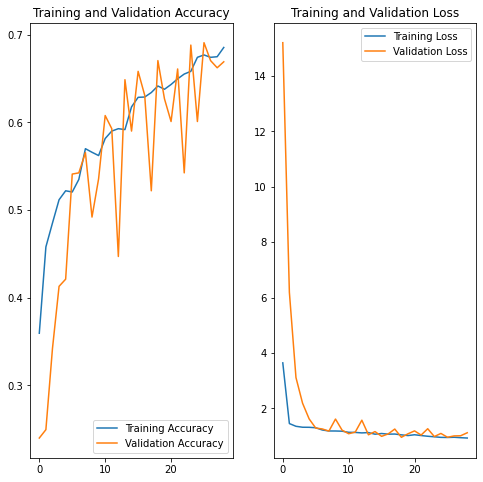

In [9]:
# How many epochs should i ran, until you get the desired/optimal accuracy and loss
# For simplicity i'm gonna go with 50
epochs = 100 

# You also specify if there is no improvement in the accuracy/loss you can stop with a callback
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10) # patience 

history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=epochs, 
                    callbacks=[early_stopping])


# Our handy dandy function to plot the accuracy and loss
def plot_acc_loss(history, epochs_ran):
  # Lets plot the accuracy and loss over epochs
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs_ran)

  # below is matplotlib api's to plot line graph
  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.savefig('H.png')

# Thats it at this point the model is trained
if (early_stopping.stopped_epoch == 0): 
  epochs_ran = epochs
else:
  epochs_ran = early_stopping.stopped_epoch+1 

plot_acc_loss(history, epochs_ran)

### Plot Confusion matrix for validation data

It gives an visual represention of how good the model is performing

Confusion matrix, without normalization


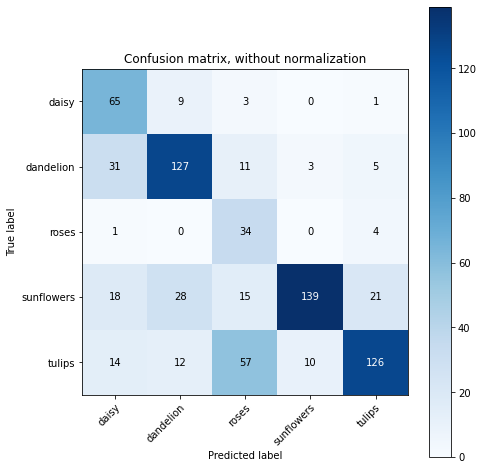

In [12]:
#Defining function for confusion matrix plot - https://analyticsindiamag.com/implementing-efficientnet-a-powerful-convolutional-neural-network/
from sklearn.metrics import confusion_matrix
from google.colab.patches import cv2_imshow

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#Print Confusion matrix
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
        xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

   # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

val_ds_u = val_ds.unbatch()
val_ds_u = list(val_ds_u.as_numpy_iterator())
img_arr = np.array([image for image, label in val_ds_u])
lbl_arr = np.array([label for image, label in val_ds_u])

val_p = model.predict(img_arr)


val_r = [np.argmax(y) for y in val_p]

plot_confusion_matrix(val_r, lbl_arr, class_names)

## Step 5: Test the model


In [13]:
# Place an url of any new images and try the results 
image_url = "https://upload.wikimedia.org/wikipedia/commons/c/ce/Daisy_G%C3%A4nsebl%C3%BCmchen_Bellis_perennis_01.jpg"

# tf cahces the data to be dowloaded, so just make sure we clean if any previous image was already stored
!rm datasets/Image.png

# Download the image to local storage
image_path = tf.keras.utils.get_file('Image.png', origin=image_url, cache_dir="./")
# Load the image from local storage using tensorflow api's 
img = tf.keras.preprocessing.image.load_img(
    image_path, 
    target_size=(IMG_WIDTH, IMG_HEIGHT)
    )
img_array = tf.keras.preprocessing.image.img_to_array(img)

img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])


print("This definitely an {} - {}".format(class_names[np.argmax(score)], round(100 * np.max(score))))

rm: cannot remove 'datasets/Image.png': No such file or directory
1261568/1256730 [==============================] - 0s 0us/step
This definitely an daisy - 99
